In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import keras
import tensorflow as tf
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from scipy.stats import chi2_contingency
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
import statsmodels.api as sm
plt.style.use('dark_background')
import warnings
warnings.filterwarnings('ignore')


<Figure size 864x432 with 0 Axes>

### make fake encoder

In [2]:
# define encoder
visible = keras.Input(shape=(120,))
# encoder level 1
e = tf.keras.layers.Dense(120)(visible)
e = tf.keras.layers.BatchNormalization()(e)
e = tf.keras.layers.LeakyReLU()(e)
# encoder level 2
e = tf.keras.layers.Dense(60)(e)
e = tf.keras.layers.BatchNormalization()(e)
e = tf.keras.layers.LeakyReLU()(e)
# encoder level 3
e = tf.keras.layers.Dense(10)(e)
e = tf.keras.layers.BatchNormalization()(e)
e = tf.keras.layers.LeakyReLU()(e)
# bottleneck
bottleneck = tf.keras.layers.Dense(1)(e)
# define decoder, level 1
d = tf.keras.layers.Dense(10)(bottleneck)
d = tf.keras.layers.BatchNormalization()(d)
d = tf.keras.layers.LeakyReLU()(d)
# decoder level 2
d = tf.keras.layers.Dense(60)(d)
d = tf.keras.layers.BatchNormalization()(d)
d = tf.keras.layers.LeakyReLU()(d)
# decoder level 3
d = tf.keras.layers.Dense(120)(d)
d = tf.keras.layers.BatchNormalization()(d)
d = tf.keras.layers.LeakyReLU()(d)
# output layer
output = tf.keras.layers.Dense(120, activation='relu')(d)
# define autoencoder model
model = keras.Model(inputs=visible, outputs=output)
model.save('./encoder2.h5')

### load data & encoder

In [3]:
# load fake data
features = np.random.randint(100, size=(9640, 120))
# split data into train test sets
tst_split = round(0.9 * features.shape[0])
X_train = features[0 : tst_split]
X_val = features[tst_split : ]
# scale data
t = MinMaxScaler().fit(X_train)
X_train = t.transform(X_train)
X_val = t.transform(X_val)

In [4]:
features.shape

(9640, 120)

In [5]:
X_train.shape

(8676, 120)

In [6]:
X_val.shape

(964, 120)

In [7]:
model = tf.keras.models.load_model('./encoder2.h5')
# compile autoencoder model
model.compile(optimizer='adam', loss='mae')
# fit the autoencoder model to reconstruct input
history = model.fit(X_train, X_train, epochs=6, batch_size=64, validation_data=(X_val,X_val))
x_train_pred = model.predict(X_train)
x_val_pred = model.predict(X_val)

Epoch 1/6
136/136 [==============================] - 4s 7ms/step - loss: 0.3056 - val_loss: 0.3015
Epoch 2/6
136/136 [==============================] - 1s 5ms/step - loss: 0.2579 - val_loss: 0.2678
Epoch 3/6
136/136 [==============================] - 1s 5ms/step - loss: 0.2570 - val_loss: 0.2657
Epoch 4/6
136/136 [==============================] - 1s 5ms/step - loss: 0.2567 - val_loss: 0.2613
Epoch 5/6
136/136 [==============================] - 1s 5ms/step - loss: 0.2563 - val_loss: 0.2592
Epoch 6/6
31/31 [==============================] - 0s 2ms/step


In [8]:
x_train_pred.shape

(8676, 120)

In [9]:
x_val_pred.shape

(964, 120)

###  Reconstruction Loss plot

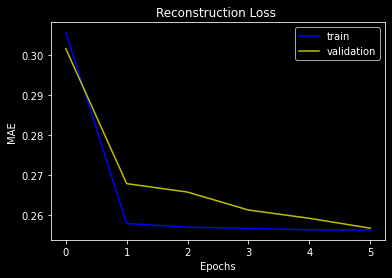

In [10]:
plt.plot(history.history['loss'], c = 'b', label='train')
plt.plot(history.history['val_loss'], c = 'y', label='validation')
plt.legend()
plt.title("Reconstruction Loss ")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.show()

### evaluate metrics

In [11]:
mets = []
train = []
val = []

mets.append('mean_squared_error')
train.append(mean_squared_error(X_train, x_train_pred))
val.append(mean_squared_error(X_val, x_val_pred))

mets.append('mean_absolute_error')
train.append(mean_absolute_error(X_train, x_train_pred))
val.append(mean_absolute_error(X_val, x_val_pred))

mets.append('r2_multi_output_regres')
train.append(MultiOutputRegressor(Ridge(random_state=123)).fit(X_train, x_train_pred).score(X_train, x_train_pred))
val.append(MultiOutputRegressor(Ridge(random_state=123)).fit(X_val, x_val_pred).score(X_val, x_val_pred))

mets.append('r2_sklearn')
train.append(r2_score(X_train, x_train_pred))
val.append(r2_score(X_val, x_val_pred))

metrics = pd.DataFrame({'metrics' : mets, 'train_set' : train, 'validation_set' : val })
metrics

,metrics,train_set,validation_set
0,mean_squared_error,0.089831,0.089899
1,mean_absolute_error,0.256205,0.256742
2,r2_multi_output_regres,0.553816,0.582214
3,r2_sklearn,-0.056729,-0.054245


## step_by_step

#### train

In [12]:
part = []
mets = []
train = []
r2_reg1_train = []
r2_sklearn_train = []
mse_train = []
mae_train = []
ind = round(len(X_train)/10)

for i in range(10):
    X = X_train[i*ind : (i+1)*ind]
    X_pred = x_train_pred[i*ind : (i+1)*ind]
    mets.append('mean_squared_error')
    train.append(mean_squared_error(X, X_pred))
    mse_train.append(mean_squared_error(X, X_pred))
    part.append(i)
    mets.append('mean_absolute_error')
    train.append(mean_absolute_error(X, X_pred))
    mae_train.append(mean_absolute_error(X, X_pred))
    part.append(i)

    mets.append('r2_multi_output_regres')
    train.append(MultiOutputRegressor(Ridge(random_state=123)).fit(X, X_pred).score(X, X_pred))
    r2_reg1_train.append(MultiOutputRegressor(Ridge(random_state=123)).fit(X, X_pred).score(X, X_pred))
    part.append(i)

    mets.append('r2_sklearn')
    train.append(r2_score(X, X_pred))
    r2_sklearn_train.append(r2_score(X, X_pred))
    part.append(i)
    
metrics = pd.DataFrame({'part':part,'metrics' : mets, 'value' : train })
metrics

,part,metrics,value
0,0,mean_squared_error,0.089868
1,0,mean_absolute_error,0.256373
2,0,r2_multi_output_regres,0.618187
3,0,r2_sklearn,-0.059431
4,1,mean_squared_error,0.089841
5,1,mean_absolute_error,0.256362
6,1,r2_multi_output_regres,0.601543
7,1,r2_sklearn,-0.055728
8,2,mean_squared_error,0.090082
9,2,mean_absolute_error,0.256409


#### validation data

In [13]:
part = []
mets = []
train = []
r2_reg1_val = []
r2_sklearn_val = []
mse_val = []
mae_val = []
ind = round(len(X_val)/10)

for i in range(10):
    X = X_val[i*ind : (i+1)*ind]
    X_pred = x_val_pred[i*ind : (i+1)*ind]
    mets.append('mean_squared_error')
    train.append(mean_squared_error(X, X_pred))
    mse_val.append(mean_squared_error(X, X_pred))
    part.append(i)
    mets.append('mean_absolute_error')
    train.append(mean_absolute_error(X, X_pred))
    mae_val.append(mean_absolute_error(X, X_pred))
    part.append(i)

    mets.append('r2_multi_output_regres')
    train.append(MultiOutputRegressor(Ridge(random_state=123)).fit(X, X_pred).score(X, X_pred))
    r2_reg1_val.append(MultiOutputRegressor(Ridge(random_state=123)).fit(X, X_pred).score(X, X_pred))
    part.append(i)

    mets.append('r2_sklearn')
    train.append(r2_score(X, X_pred))
    r2_sklearn_val.append(r2_score(X, X_pred))
    part.append(i)
    
metrics2 = pd.DataFrame({'part':part,'metrics' : mets, 'value' : train })
metrics2

,part,metrics,value
0,0,mean_squared_error,0.088736
1,0,mean_absolute_error,0.255223
2,0,r2_multi_output_regres,0.946338
3,0,r2_sklearn,-0.062100
4,1,mean_squared_error,0.090885
5,1,mean_absolute_error,0.257154
6,1,r2_multi_output_regres,0.959912
7,1,r2_sklearn,-0.075011
8,2,mean_squared_error,0.090261
9,2,mean_absolute_error,0.256340


#### R2 multi output regression

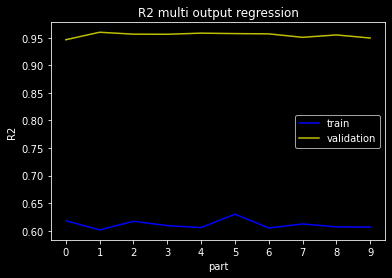

In [14]:
plt.plot( r2_reg1_train, c = 'b', label='train')
plt.plot( r2_reg1_val, c = 'y', label='validation')
plt.legend()
plt.xticks(range(10))
plt.title("R2 multi output regression")
plt.xlabel("part")
plt.ylabel("R2")
plt.show()

#### R2 sklearn

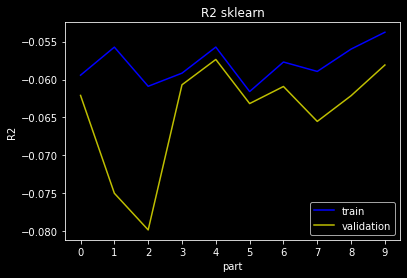

In [15]:
plt.plot( r2_sklearn_train, c = 'b', label='train')
plt.plot( r2_sklearn_val, c = 'y', label='validation')
plt.legend()
plt.xticks(range(10))
plt.title("R2 sklearn")
plt.xlabel("part")
plt.ylabel("R2")
plt.show()

#### MSE

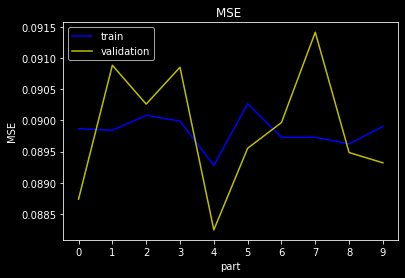

In [16]:
plt.plot( mse_train, c = 'b', label='train')
plt.plot( mse_val, c = 'y', label='validation')
plt.legend()
plt.xticks(range(10))
plt.title("MSE ")
plt.xlabel("part")
plt.ylabel("MSE")
plt.show()

#### MAE

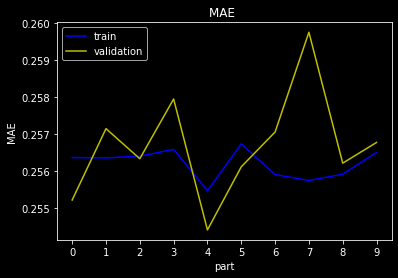

In [17]:
plt.plot( mae_train, c = 'b', label='train')
plt.plot( mae_val, c = 'y', label='validation')
plt.legend()
plt.xticks(range(10))
plt.title("MAE ")
plt.xlabel("part")
plt.ylabel("MAE")
plt.show()

#### flatten values

In [18]:
mets = []
train = []
val = []

mets.append('mean_squared_error')
train.append(mean_squared_error(X_train.flatten(), x_train_pred.flatten()))
val.append(mean_squared_error(X_val.flatten(), x_val_pred.flatten()))

mets.append('mean_absolute_error')
train.append(mean_absolute_error(X_train.flatten(), x_train_pred.flatten()))
val.append(mean_absolute_error(X_val.flatten().flatten(), x_val_pred.flatten()))

mets.append('r2_sklearn')
train.append(r2_score(X_train.flatten(), x_train_pred.flatten()))
val.append(r2_score(X_val.flatten(), x_val_pred.flatten()))

metrics3 = pd.DataFrame({'metrics' : mets, 'train_set' : train, 'validation_set' : val })
metrics3

,metrics,train_set,validation_set
0,mean_squared_error,0.089831,0.089899
1,mean_absolute_error,0.256205,0.256742
2,r2_sklearn,-0.056526,-0.053441


In [19]:
# train
x1 = X_train.flatten()
x1 = sm.add_constant(x1)
reg_train = sm.OLS(x_train_pred.flatten(), x1).fit()
reg_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2350.
Date:                Mon, 31 Oct 2022   Prob (F-statistic):               0.00
Time:                        19:47:32   Log-Likelihood:             1.0990e+06
No. Observations:             1041120   AIC:                        -2.198e+06
Df Residuals:                 1041118   BIC:                        -2.198e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4872      0.000   2975.074      0.000       0.487       0.488
x1             0.0137      0.000     48.475      0.000       0.013       0.014
==============================================================================
Omnibus:                   418239.908   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          5552901.967
Skew:                          -1.568   Prob(JB):                         0.00
Kurtosis:                      13.871   Cond. No.                         4.35
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
# validation
x2 = X_val.flatten()
x2 = sm.add_constant(x2)
reg_val = sm.OLS(x_val_pred.flatten(), x2).fit()
reg_val.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     228.7
Date:                Mon, 31 Oct 2022   Prob (F-statistic):           1.31e-51
Time:                        19:47:32   Log-Likelihood:             1.2617e+05
No. Observations:              115680   AIC:                        -2.523e+05
Df Residuals:                  115678   BIC:                        -2.523e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4871      0.000   1027.451      0.000       0.486       0.488
x1             0.0124      0.001     15.121      0.000       0.011       0.014
==============================================================================
Omnibus:                    50689.997   Durbin-Watson:                   1.904
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           820792.144
Skew:                          -1.691   Prob(JB):                         0.00
Kurtosis:                      15.604   Cond. No.                         4.34
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Chi2_contingency

#### train_set

In [21]:
data = [X_train.tolist(), x_train_pred.tolist()]
chi_square_dict = {'stats':chi2_contingency(data)[0], 'p':chi2_contingency(data)[1],'dof':chi2_contingency(data)[2]}
print(f'train_chi2_contingency: \n {chi_square_dict}')

train_chi2_contingency: 
 {'stats': 191471.10916222224, 'p': 1.0, 'dof': 2073444}


#### validation_set

In [22]:
data = [X_val.tolist(), x_val_pred.tolist()]
chi_square_dict = {'stats':chi2_contingency(data)[0], 'p':chi2_contingency(data)[1],'dof':chi2_contingency(data)[2]}
print(f'validation_chi2_contingency: \n {chi_square_dict}')

validation_chi2_contingency: 
 {'stats': 21218.74807085593, 'p': 1.0, 'dof': 230276}
